In [172]:
####################################################################
# Stats
import numpy as np
import pandas as pd
from scipy import stats
####################################################################
# Plotting
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import plotly.graph_objects as go
import seaborn as sns
####################################################################
# General
from pathlib import Path
import os
import pickle
from tqdm import tqdm
from config import model_config
import math
####################################################################
# sklearn
from sklearn.preprocessing import LabelEncoder
####################################################################
# Local packages
from regression import reg

In [173]:
df = pd.read_pickle(Path('../data/df_clean_w_outliers.pkl'))
df['PE_number'] = df.index.get_level_values(0).str[:-2]
print(df.shape)
print(len(df['PE_number'].unique()))
df.head()

(104, 121)
52


,pe_number_clean,patient_id,gender_pe,series_id,slice_number,centralartery,apical_rs1,posterior_rs2,anterior_rs3,lateral_rs4,...,peak_pa_elastance_ea_mmhg_ml_m2,hyperventilation,vq_date,hyperventilation_num,mpap_co_ratio,normal,dob_mask_cl,study_age_cl,study_date_mask_cl,PE_number
PE1_0,PE1,HB046619,M,3.0,174.0,12.730400,0.476038,0.839102,0.308990,0.784063,...,1.170445,1.0,2027-09-30,1.0,1.537996,0,1977-12-13,49.886379,2027-11-02,PE1
PE12_0,PE12,HB046622,M,4.0,264.0,0.000000,0.025181,0.000000,0.032875,0.510612,...,0.540537,1.0,2031-09-25,1.0,1.391943,0,1986-05-02,45.412731,2031-09-30,PE12
PE12_1,PE12,HB046622,M,2.0,95.0,5.267850,0.336170,0.075102,0.000000,0.461339,...,0.540537,1.0,2031-09-25,1.0,1.391943,0,1986-05-02,45.412731,2031-09-30,PE12
PE14_0,PE14,HB046616,F,3.0,167.0,1.082940,0.000000,0.000000,0.000000,0.000000,...,0.650262,1.0,2028-11-16,1.0,1.588670,0,1997-04-05,31.616701,2028-11-16,PE14
PE15_0,PE15,HB046618,F,3.0,330.0,0.001022,0.000000,0.000000,0.000000,0.005451,...,0.559831,0.0,2029-04-18,0.0,1.940946,0,2010-08-21,18.699521,2029-05-03,PE15


# Hemodynamic Variable Calculations

In [174]:
# Hemodynamic
df['mpap_co_ratio'] = df['peak_measured_mpap_mmhg'] / df['peak_fick_co']

# Sequence Datawork

In [175]:
def get_n_smallest_date(data, n):
	"""
	:param data: Date column.
	:param n: nth smallest date to return.
	:return: nth smallest date.
	"""
	if data.shape[-1] < n:
		return pd.NaT
	else:
		return data.nsmallest(n, keep='all')[-1]

def calculate_percent_change(data, initial_index, final_index):
	"""
	:param data: Data for group.
	:param initial_index: First patient observation for percent change calculation.
	:param final_index: Last patient observation for percent change calculation.
	:return: Percent change, if two conditions are satisfied:
		- Data exists (first logical condition).
		- Initial observation is not zero (second logical condition) to avoid div by zero.
	"""
	if len(data) > final_index and data.iloc[initial_index] != 0:
		return (data.iloc[final_index] / data.iloc[initial_index]) - 1
	else:
		return np.nan
	
def count_positive_values(row):
    """
    :param row: Row of values to count over.
    :return: Count of positive values. 
    """
    return sum(row > 0)

# Create columns for the nth smallest date
for obs_number in range(1, int(df.pe_obs.max())+1):
	df[f"date_of_obs_{int(obs_number-1)}"] = (
		df
		.groupby('PE_number')['study_date_mask_pe']
		.transform(lambda x: get_n_smallest_date(x, obs_number))
	)
	
# Calculate durations from date to date and percent changes
# Store results in a dictionary to then concat with the original df
# (see https://github.com/pandas-dev/pandas/issues/42477)
dict_of_columns = dict()
for start_obs in range(0, int(df.pe_obs.max())-1):
	for end_obs in range(1, int(df.pe_obs.max())):
		if start_obs >= end_obs:
			continue
		# Calculate durations
		dict_of_columns[f'duration_{start_obs}_to_{end_obs}_days'] = (
			(df[f'date_of_obs_{end_obs}'] - df[f'date_of_obs_{start_obs}']).dt.days
		)
		# Calculate percent changes
		for feature in model_config.num_targets:
			dict_of_columns[f'pct_change_{feature}_{start_obs}_to_{end_obs}'] = (
				df
				.groupby('PE_number')[feature]
				.transform(calculate_percent_change, start_obs, end_obs)
			)
df = pd.concat([df, pd.DataFrame(dict_of_columns)], axis=1)

# Calculate percent change per day
df['pct_change_total_clot_burden_per_day_0_to_1'] = df['pct_change_total_clot_burden_0_to_1'] / df['duration_0_to_1_days']

# Get count of positive clot burden values across all segments 
# Meant to give a sense of the distribution of clot burden
segment_clot_burden_columns = list(set(model_config.num_targets).difference(set(['total_clot_burden'])))
df['num_positive_clot_burden_segments'] = df[segment_clot_burden_columns].apply(count_positive_values, axis=1)

# Check shape
print(f"New shape: {df.shape}")

# Check results
df[[
	'study_date_mask_pe', 
	'date_of_obs_0', 
	'date_of_obs_1', 
	'date_of_obs_2', 
	'date_of_obs_3', 
	'duration_0_to_1_days',
	'duration_0_to_2_days',
	'pct_change_centralartery_0_to_1',
	'num_positive_clot_burden_segments',
]].head(10)

New shape: (104, 459)


,study_date_mask_pe,date_of_obs_0,date_of_obs_1,date_of_obs_2,date_of_obs_3,duration_0_to_1_days,duration_0_to_2_days,pct_change_centralartery_0_to_1,num_positive_clot_burden_segments
PE1_0,2023-10-30,2023-10-30,NaT,NaT,NaT,NaN,NaN,NaN,17
PE12_0,2030-10-10,2030-10-10,2031-09-25,NaT,NaT,350.0,NaN,NaN,8
PE12_1,2031-09-25,2030-10-10,2031-09-25,NaT,NaT,350.0,NaN,NaN,16
PE14_0,2028-10-10,2028-10-10,NaT,NaT,NaT,NaN,NaN,NaN,7
PE15_0,2028-01-31,2028-01-31,2028-08-24,2029-03-13,2030-07-11,206.0,407.0,-1.000000,5
PE15_1,2028-08-24,2028-01-31,2028-08-24,2029-03-13,2030-07-11,206.0,407.0,-1.000000,0
PE15_2,2029-03-13,2028-01-31,2028-08-24,2029-03-13,2030-07-11,206.0,407.0,-1.000000,1
PE15_3,2030-07-11,2028-01-31,2028-08-24,2029-03-13,2030-07-11,206.0,407.0,-1.000000,1
PE16_0,2026-10-10,2026-10-10,2026-11-26,NaT,NaT,47.0,NaN,-0.913992,17
PE16_1,2026-11-26,2026-10-10,2026-11-26,NaT,NaT,47.0,NaN,-0.913992,9


In [176]:
print(df['pct_change_total_clot_burden_0_to_1'].mean())
print(df['duration_0_to_1_days'].mean())
print(df['pct_change_total_clot_burden_per_day_0_to_1'].mean())

0.5454233942158376
204.2875
0.07184301991267722


In [177]:
df.loc[df['duration_0_to_1_days']==0, ['duration_0_to_1_days', 'series_id']]

,duration_0_to_1_days,series_id


In [178]:
df['num_scans'] = df.groupby('PE_number')['total_clot_burden'].transform('count')

# Additional Date and Duration Datawork 

In [179]:
# Get total number of visits by PE_number
# Can use later to subset into patients with multiple observations.
df['total_visits'] = df.groupby('PE_number')['PE_number'].transform('count')

# Compute number of days since first observation
# Can use later to line up timelines rather than use masked (meaningless) dates.
df = df.sort_values(by='study_date_mask_pe')
df['date_first_visit'] = df.groupby('PE_number')['study_date_mask_pe'].transform(min)
df['date_last_visit'] = df.groupby('PE_number')['study_date_mask_pe'].transform(max)
df['date_range'] = (df['date_last_visit'] - df['date_first_visit']).dt.days
df['duration_0_to_t_days'] = (df['study_date_mask_pe'] - df['date_first_visit']).dt.days

# Compute number of days since iCPET study
df['duration_t_to_iCPET_days'] = (df['study_date_mask_pe'] - df['study_date_mask_cl']).dt.days

# Compute number of days since VQ study
df['duration_t_to_VQ_days'] = (df['study_date_mask_pe'] - df['vq_date']).dt.days

# Compute previous clot burden and pct_change in clot burden
# To be used for graphing/segmenting/comparisons
df = df.sort_values(by=['PE_number', 'study_date_mask_pe'])
df['previous_clot_burden'] = df.groupby('PE_number')['total_clot_burden'].shift()
df['previous_study_date'] = df.groupby('PE_number')['study_date_mask_pe'].shift()
df['pct_change_clot_burden'] = (df['total_clot_burden'] / df['previous_clot_burden']) - 1

# Compute max number of days from first visit
# Can determine if patient has 'long' or 'short' term observations
df['duration_prev_to_t_days'] = (df['study_date_mask_pe'] - df['previous_study_date']).dt.days
df['change_clot_burden_per_day'] = (df['total_clot_burden'] - df['previous_clot_burden']) / df['duration_prev_to_t_days']
df['max_days_from_first_visit'] = df.groupby('PE_number')['duration_0_to_t_days'].transform(max)
df['long_term_obs'] = df['max_days_from_first_visit'] > 365

# Calculate maximum clot burden and categorize into groups
# May make visualization of progression somewhat easier
df['max_clot_burden'] = df.groupby('PE_number')['total_clot_burden'].transform(max)
qcut_labels= ['0-20 percentile', '20-40 percentile', '40-60 percentile', '60-80 percentile', '80-100 percentile']
df['max_clot_burden_category'] = pd.qcut(df['max_clot_burden'], q=len(qcut_labels), labels=qcut_labels)

# Create numeric PE number for graphing and sorting
df['PE_number_num'] = pd.to_numeric(df['PE_number'].str.replace('PE', '')).astype(np.float64)

print(df.shape)
df.head(10)

(104, 477)


,pe_number_clean,patient_id,gender_pe,series_id,slice_number,centralartery,apical_rs1,posterior_rs2,anterior_rs3,lateral_rs4,...,previous_clot_burden,previous_study_date,pct_change_clot_burden,duration_prev_to_t_days,change_clot_burden_per_day,max_days_from_first_visit,long_term_obs,max_clot_burden,max_clot_burden_category,PE_number_num
PE1_0,PE1,HB046619,M,3.0,174.0,12.730400,0.476038,0.839102,0.308990,0.784063,...,NaN,NaT,NaN,NaN,NaN,0.0,False,20.184788,60-80 percentile,1.0
PE11_0,PE11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaN,NaN,False,NaN,NaN,11.0
PE12_0,PE12,HB046622,M,4.0,264.0,0.000000,0.025181,0.000000,0.032875,0.510612,...,NaN,NaT,NaN,NaN,NaN,350.0,False,9.495008,40-60 percentile,12.0
PE12_1,PE12,HB046622,M,2.0,95.0,5.267850,0.336170,0.075102,0.000000,0.461339,...,1.428313,2030-10-10,5.647706,350.0,0.023048,350.0,False,9.495008,40-60 percentile,12.0
PE14_0,PE14,HB046616,F,3.0,167.0,1.082940,0.000000,0.000000,0.000000,0.000000,...,NaN,NaT,NaN,NaN,NaN,0.0,False,1.845900,20-40 percentile,14.0
PE15_0,PE15,HB046618,F,3.0,330.0,0.001022,0.000000,0.000000,0.000000,0.005451,...,NaN,NaT,NaN,NaN,NaN,892.0,True,0.153638,0-20 percentile,15.0
PE15_1,PE15,HB046618,F,3.0,323.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.153638,2028-01-31,-1.000000,206.0,-0.000746,892.0,True,0.153638,0-20 percentile,15.0
PE15_2,PE15,HB046618,F,2.0,304.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,2028-08-24,inf,201.0,0.000030,892.0,True,0.153638,0-20 percentile,15.0
PE15_3,PE15,HB046618,F,2.0,383.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.005953,2029-03-13,1.791234,485.0,0.000022,892.0,True,0.153638,0-20 percentile,15.0
PE16_0,PE16,HB046615,F,3.0,168.0,11.768300,0.000000,0.519093,0.108929,0.563471,...,NaN,NaT,NaN,NaN,NaN,47.0,False,24.140455,80-100 percentile,16.0


# Data for numerical tests

## Initial CTA

In [180]:
num_data_initial = df.copy()
print(num_data_initial.shape)
# limit to first observations
num_data_initial = num_data_initial.loc[num_data_initial['pe_obs']==0, :]

# Reset index
tuples = list(zip(num_data_initial['PE_number'], num_data_initial['resolved_pe']))
multi_index = pd.MultiIndex.from_tuples(tuples)
num_data_initial.index = multi_index

# Subset to numeric data and reset index
num_data_initial = num_data_initial.select_dtypes(['int', 'float'])
num_data_initial.index.names = ['PE_number', 'resolved_pe']
num_data_initial = num_data_initial.reset_index()

# Drop columns with all NaN
num_data_initial = num_data_initial.dropna(axis=1, how='all')

print(len(num_data_initial['PE_number'].unique()))
print(num_data_initial['resolved_pe'].value_counts())

num_data_initial.head(10)

(104, 477)
52
Unresolved    29
Resolved      17
Name: resolved_pe, dtype: int64


,PE_number,resolved_pe,series_id,slice_number,centralartery,apical_rs1,posterior_rs2,anterior_rs3,lateral_rs4,medial_rs5,...,num_positive_clot_burden_segments,num_scans,total_visits,date_range,duration_0_to_t_days,duration_t_to_iCPET_days,duration_t_to_VQ_days,max_days_from_first_visit,max_clot_burden,PE_number_num
0,PE1,Resolved,3.0,174.0,12.730400,0.476038,0.839102,0.308990,0.784063,0.546527,...,17,1,1,0.0,0.0,-1464.0,-1431.0,0.0,20.184788,1.0
1,PE11,Resolved,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,11.0
2,PE12,Unresolved,4.0,264.0,0.000000,0.025181,0.000000,0.032875,0.510612,0.090231,...,8,2,2,350.0,0.0,-355.0,-350.0,350.0,9.495008,12.0
3,PE14,Unresolved,3.0,167.0,1.082940,0.000000,0.000000,0.000000,0.000000,0.000000,...,7,1,1,0.0,0.0,-37.0,-37.0,0.0,1.845900,14.0
4,PE15,Unresolved,3.0,330.0,0.001022,0.000000,0.000000,0.000000,0.005451,0.000000,...,5,4,4,892.0,0.0,-458.0,-443.0,892.0,0.153638,15.0
5,PE16,Unresolved,3.0,168.0,11.768300,0.000000,0.519093,0.108929,0.563471,0.018827,...,17,2,2,47.0,0.0,-264.0,-296.0,47.0,24.140455,16.0
6,PE17,Unresolved,2.0,215.0,13.507800,0.537025,0.330620,1.658040,0.310226,0.000000,...,14,1,1,0.0,0.0,-564.0,-134.0,0.0,23.634024,17.0
7,PE18,Resolved,4.0,228.0,10.763400,1.129710,0.185610,0.007065,0.508018,0.267817,...,19,4,4,2308.0,0.0,-2407.0,-2314.0,2308.0,20.814575,18.0
8,PE19,Unresolved,4.0,251.0,3.418750,0.041274,0.466177,0.252804,0.358201,0.898081,...,15,1,1,0.0,0.0,-169.0,-147.0,0.0,7.783488,19.0
9,PE2,Resolved,4.0,183.0,17.666000,0.537468,0.213579,0.533948,0.158424,0.000000,...,19,1,1,0.0,0.0,-286.0,-152.0,0.0,22.408161,2.0


## Last CTA Prior to VQ Date

In [181]:
num_data_last_prior = df.copy()
print(num_data_last_prior.shape)

# limit to first prior observation to iCPET
num_data_last_prior = num_data_last_prior[num_data_last_prior['duration_t_to_VQ_days'] <= 0]
num_data_last_prior = num_data_last_prior.sort_values('duration_t_to_VQ_days')
num_data_last_prior = num_data_last_prior.groupby('PE_number').last().reset_index()
print(num_data_last_prior.shape)


# Reset index
tuples = list(zip(num_data_last_prior['PE_number'], num_data_last_prior['resolved_pe']))
multi_index = pd.MultiIndex.from_tuples(tuples)
num_data_last_prior.index = multi_index
print(num_data_last_prior.shape)

# Subset to numeric data and reset index
num_data_last_prior = num_data_last_prior.select_dtypes(['int', 'float'])
num_data_last_prior.index.names = ['PE_number', 'resolved_pe']
num_data_last_prior = num_data_last_prior.reset_index()
print(num_data_last_prior.shape)

# Drop columns with all NaN
num_data_last_prior = num_data_last_prior.dropna(axis=1, how='all')
print(num_data_last_prior.shape)

print(len(num_data_last_prior['PE_number'].unique()))
print(num_data_last_prior['resolved_pe'].value_counts())

num_data_last_prior.head(10)

(104, 477)
(35, 477)
(35, 477)
(35, 439)
(35, 374)
35
Unresolved    24
Resolved      11
Name: resolved_pe, dtype: int64


,PE_number,resolved_pe,series_id,slice_number,centralartery,apical_rs1,posterior_rs2,anterior_rs3,lateral_rs4,medial_rs5,...,duration_0_to_t_days,duration_t_to_iCPET_days,duration_t_to_VQ_days,previous_clot_burden,pct_change_clot_burden,duration_prev_to_t_days,change_clot_burden_per_day,max_days_from_first_visit,max_clot_burden,PE_number_num
0,PE1,Resolved,3.0,174.0,12.730400,0.476038,0.839102,0.308990,0.784063,0.546527,...,0.0,-1464.0,-1431.0,NaN,NaN,NaN,NaN,0.0,20.184788,1.0
1,PE12,Unresolved,2.0,95.0,5.267850,0.336170,0.075102,0.000000,0.461339,0.000000,...,350.0,-5.0,0.0,1.428313,5.647706,350.0,0.023048,350.0,9.495008,12.0
2,PE14,Unresolved,3.0,167.0,1.082940,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,-37.0,-37.0,NaN,NaN,NaN,NaN,0.0,1.845900,14.0
3,PE15,Unresolved,2.0,304.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,407.0,-51.0,-36.0,0.000000,inf,201.0,0.000030,892.0,0.153638,15.0
4,PE16,Unresolved,3.0,184.0,1.012170,0.000000,0.026150,0.018459,0.000000,0.000000,...,47.0,-217.0,-249.0,24.140455,-0.892248,47.0,-0.458282,47.0,24.140455,16.0
5,PE17,Unresolved,2.0,215.0,13.507800,0.537025,0.330620,1.658040,0.310226,0.000000,...,0.0,-564.0,-134.0,NaN,NaN,NaN,NaN,0.0,23.634024,17.0
6,PE18,Resolved,2.0,211.0,0.962814,0.000000,0.009888,0.048203,0.171181,0.000000,...,2308.0,-99.0,-6.0,0.150423,14.262294,13.0,0.165029,2308.0,20.814575,18.0
7,PE19,Unresolved,4.0,251.0,3.418750,0.041274,0.466177,0.252804,0.358201,0.898081,...,0.0,-169.0,-147.0,NaN,NaN,NaN,NaN,0.0,7.783488,19.0
8,PE2,Resolved,4.0,183.0,17.666000,0.537468,0.213579,0.533948,0.158424,0.000000,...,0.0,-286.0,-152.0,NaN,NaN,NaN,NaN,0.0,22.408161,2.0
9,PE20,Unresolved,2.0,303.0,8.062790,0.110397,0.008037,0.057525,0.064293,0.001269,...,0.0,-302.0,0.0,NaN,NaN,NaN,NaN,0.0,9.856213,20.0


# Data for categorical tests

In [182]:
cat_data_for_tests = df.copy()

# limit to first observations
cat_data_for_tests = cat_data_for_tests.loc[cat_data_for_tests['pe_obs']==0, :]

cat_data_for_tests.index = cat_data_for_tests['PE_number']
cat_data_for_tests = cat_data_for_tests.select_dtypes(['category'])
cat_data_for_tests.shape

(52, 20)

In [183]:
cat_data_last_prior = df.copy().dropna(subset=['duration_t_to_VQ_days'])

# limit to first prior observation to iCPET
cat_data_last_prior = cat_data_last_prior[cat_data_last_prior['duration_t_to_VQ_days'] <= 0]
cat_data_last_prior = cat_data_last_prior.sort_values('duration_t_to_VQ_days')
cat_data_last_prior = cat_data_last_prior.groupby('PE_number').last().reset_index()

cat_data_last_prior.index = cat_data_last_prior['PE_number']
cat_data_last_prior = cat_data_last_prior.select_dtypes(['category'])
cat_data_last_prior.shape

(35, 20)

# Numerical tests

In [184]:
def two_group_num_tests(group0_data, group1_data):
    """
    Conduct two-group statistical tests (t-test, Mann-Whitney U, and rank sums).
    """
    group0_data = group0_data.dropna()
    group1_data = group1_data.dropna()
    all_data = pd.concat([group0_data, group1_data], axis=0)
	
    summary_statistics = dict(
        n_group0 = len(group0_data),
        n_group1 = len(group1_data),
        n_all = len(all_data),
        mean_group0 = group0_data.mean(),
        mean_group1 = group1_data.mean(),
        mean_all = all_data.mean(),
        se_group0 = group0_data.std() / np.sqrt(len(group0_data)),
        se_group1 = group1_data.std() / np.sqrt(len(group1_data)),
        se_all = all_data.std() / np.sqrt(len(all_data)),
    )
    
    n_cutoff = 2
    if group0_data.shape[-1] <= n_cutoff or group1_data.shape[-1] <= n_cutoff:
        return summary_statistics
    if np.isclose(group0_data.mean(), group1_data.mean(), equal_nan=True):
        return summary_statistics
    else:
        statistical_tests = dict(
            ttest_ind_pvalue = stats.ttest_ind(group0_data, group1_data, equal_var=False, nan_policy='omit').pvalue,
            mannwhitneyu_pvalue = stats.mannwhitneyu(group0_data, group1_data, nan_policy='omit').pvalue,
            ranksums_pvalue = stats.ranksums(group0_data, group1_data, nan_policy='omit').pvalue,
        )
        return {**summary_statistics, **statistical_tests}

def run_num_tests(df, grouper):
    """
    Conduct two-group statistcal tests across all columns of 
    """
    cols_to_exclude_from_tests = [
    	'resolved_pe',
    	'days_from_first_visit',
    	'series_id',
    	'slice_number',
    	'pe_obs',
    	'PE_number_num',
    ]
    
    group_names = list(df.groupby(grouper).groups.keys())
    for i, n in enumerate(group_names):
    	print(f"Group {i} = {n}")
    
    df_data = dict()
    for feat in df.select_dtypes(['int', 'float']).columns.difference(cols_to_exclude_from_tests):
    	data = [group_data[feat] for _, group_data in df.groupby(grouper)]
    	df_data[feat] = two_group_num_tests(data[0], data[1])
    
    icpet_num_tests = pd.DataFrame.from_dict(df_data, orient='index')
    icpet_num_tests['ttest_ind_signif'] = icpet_num_tests['ttest_ind_pvalue'].apply(reg.add_significance)
    icpet_num_tests['mannwhitneyu_signif'] = icpet_num_tests['mannwhitneyu_pvalue'].apply(reg.add_significance)
    icpet_num_tests['ranksums_signif'] = icpet_num_tests['ranksums_pvalue'].apply(reg.add_significance)
    icpet_num_tests['icpet_num_feat'] = list(pd.Series(icpet_num_tests.index.values).apply(lambda x: x in model_config.icpet_num_feat))
    icpet_num_tests['body_feat'] = list(pd.Series(icpet_num_tests.index.values).apply(lambda x: x in model_config.body_feat))
    icpet_num_tests['num_targets'] = list(pd.Series(icpet_num_tests.index.values).apply(lambda x: x in model_config.num_targets))
    icpet_num_tests['cardiopulmonary_feat'] = list(pd.Series(icpet_num_tests.index.values).apply(lambda x: x in model_config.cardiopulmonary_feat))
    icpet_num_tests['controls'] = list(pd.Series(icpet_num_tests.index.values).apply(lambda x: x in model_config.controls))

    return icpet_num_tests
    


## Initial CTPA

In [185]:
print(f"n={num_data_initial.dropna(subset=['total_clot_burden', 'resolved_pe']).shape[0]}")
print(num_data_initial.dropna(subset=['total_clot_burden', 'resolved_pe'])['resolved_pe'].value_counts())
num_tests_initial = run_num_tests(num_data_initial, 'resolved_pe')
num_tests_initial.to_csv('../output/summary/num_tests_initial.csv')
num_tests_initial.head()

n=44
Unresolved    28
Resolved      16
Name: resolved_pe, dtype: int64
Group 0 = Resolved
Group 1 = Unresolved


C:\Users\qauster\AppData\Local\Temp\ipykernel_5600\2676884269.py:28: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  ttest_ind_pvalue = stats.ttest_ind(group0_data, group1_data, equal_var=False, nan_policy='omit').pvalue,


,n_group0,n_group1,n_all,mean_group0,mean_group1,mean_all,se_group0,se_group1,se_all,ttest_ind_pvalue,mannwhitneyu_pvalue,ranksums_pvalue,ttest_ind_signif,mannwhitneyu_signif,ranksums_signif,icpet_num_feat,body_feat,num_targets,cardiopulmonary_feat,controls
a_diameter,16,28,44,26.434250,22.799375,24.121148,1.331812,0.607956,0.666173,0.021396,0.008118,0.007830,*,**,**,False,False,False,True,False
age,17,29,46,59.058824,48.517241,52.413043,3.262387,2.859011,2.276020,0.020006,0.028024,0.027283,*,*,*,False,False,False,False,True
airway_ratio,16,28,44,0.018602,0.042720,0.033950,0.005914,0.007504,0.005483,0.015474,0.017616,0.017371,*,*,*,False,False,False,True,False
airway_volume,16,28,44,0.060878,0.050287,0.054139,0.005197,0.003426,0.002953,0.099978,0.085428,0.083234,,,,False,False,False,True,False
anterior_basal_rs8,16,28,44,0.281032,0.225020,0.245388,0.088113,0.080384,0.059863,0.641427,0.450936,0.449456,,,,False,False,True,False,False


In [186]:
num_data_initial.duration_t_to_VQ_days.median()

-147.0

In [187]:
num_data_initial.duration_t_to_VQ_days.describe()

count      41.000000
mean     -322.853659
std       704.077857
min     -2722.000000
25%      -324.000000
50%      -147.000000
75%       -37.000000
max       716.000000
Name: duration_t_to_VQ_days, dtype: float64

In [188]:
counts = num_data_initial[['num_scans', 'resolved_pe']].value_counts().sort_index(level=0).unstack()
counts = counts.drop(index=0)
counts.loc['total', :] = counts.sum(axis=0)
counts

resolved_pe,Resolved,Unresolved
num_scans,,
1,12.0,8.0
2,2.0,10.0
3,1.0,5.0
4,1.0,3.0
6,NaN,1.0
7,NaN,1.0
total,16.0,28.0


In [189]:
num_data_initial.loc[num_data_initial['age'] > 65, 'resolved_pe'].value_counts()

Resolved      6
Unresolved    4
Name: resolved_pe, dtype: int64

In [190]:
num_data_initial.groupby('resolved_pe')[['pct_change_total_clot_burden_0_to_1', 'duration_0_to_1_days', 'pct_change_total_clot_burden_per_day_0_to_1']].mean()

,pct_change_total_clot_burden_0_to_1,duration_0_to_1_days,pct_change_total_clot_burden_per_day_0_to_1
resolved_pe,,,
Resolved,-0.596813,299.50,-0.009099
Unresolved,1.528442,197.15,0.003585


## Last CTPA Prior to iCPET

In [191]:
print(f"n={num_data_last_prior.shape[0]}")
print(num_data_last_prior['resolved_pe'].value_counts())
num_tests_last_prior = run_num_tests(num_data_last_prior, 'resolved_pe')
num_tests_last_prior.to_csv('../output/summary/num_tests_last_prior_to_icpet.csv')
num_tests_last_prior.head()

n=35
Unresolved    24
Resolved      11
Name: resolved_pe, dtype: int64
Group 0 = Resolved
Group 1 = Unresolved


C:\Users\qauster\AppData\Local\miniconda3\envs\pe_env\lib\site-packages\scipy\stats\_stats_py.py:1182: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - mean
C:\Users\qauster\AppData\Local\Temp\ipykernel_5600\2676884269.py:28: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  ttest_ind_pvalue = stats.ttest_ind(group0_data, group1_data, equal_var=False, nan_policy='omit').pvalue,
C:\Users\qauster\AppData\Local\Temp\ipykernel_5600\2676884269.py:28: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  ttest_ind_pvalue = stats.ttest_ind(group0_data, group1_data, equal_var=False, nan_policy='omit').pvalue,


,n_group0,n_group1,n_all,mean_group0,mean_group1,mean_all,se_group0,se_group1,se_all,ttest_ind_pvalue,mannwhitneyu_pvalue,ranksums_pvalue,ttest_ind_signif,mannwhitneyu_signif,ranksums_signif,icpet_num_feat,body_feat,num_targets,cardiopulmonary_feat,controls
a_diameter,11,24,35,26.730627,22.861292,24.077369,1.810982,0.656554,0.773315,0.066312,0.018129,0.017278,,*,*,False,False,False,True,False
age,11,24,35,60.818182,49.291667,52.914286,3.928493,2.970555,2.522294,0.028912,0.032896,0.031573,*,*,*,False,False,False,False,True
airway_ratio,11,24,35,0.019459,0.021353,0.020758,0.009211,0.006423,0.005196,0.867728,0.745269,0.749119,,,,False,False,False,True,False
airway_volume,11,24,35,0.055862,0.045652,0.048861,0.004310,0.003817,0.003023,0.088296,0.052798,0.050661,,,,False,False,False,True,False
anterior_basal_rs8,11,24,35,0.200535,0.256445,0.238873,0.099527,0.088059,0.067324,0.677539,0.633080,0.631440,,,,False,False,True,False,False


In [192]:
num_data_last_prior.groupby('resolved_pe')['total_clot_burden'].apply(lambda x: sum(x > 0))

resolved_pe
Resolved      11
Unresolved    24
Name: total_clot_burden, dtype: int64

In [193]:
int(num_data_last_prior.duration_t_to_VQ_days.median())

-37

In [194]:
counts = num_data_last_prior[['num_scans', 'resolved_pe']].value_counts().sort_index(level=0).unstack()
counts.loc['total', :] = counts.sum(axis=0)
counts

resolved_pe,Resolved,Unresolved
num_scans,,
1,8.0,7.0
2,2.0,8.0
3,NaN,5.0
4,1.0,2.0
6,NaN,1.0
7,NaN,1.0
total,11.0,24.0


# Categorical Tests

In [195]:
def cat_tests(data, feature):
	data = data.dropna(subset=feature).astype(str)
	# Get counts and proportions for groups
	counts_by_resolved_and_feat = data.groupby(['resolved_pe', feature])[feature].count()
	counts_by_resolved = data.groupby(['resolved_pe'])[feature].count()
	proportions = counts_by_resolved_and_feat / counts_by_resolved
	chi2_pvalue = stats.chi2_contingency(counts_by_resolved_and_feat.unstack().fillna(0)).pvalue
	
	# Create multiindex for df
	varname_array = [feature] * len(counts_by_resolved_and_feat)
	multiindex_array = list(zip(proportions.index.get_level_values(0), varname_array, proportions.index.get_level_values(1)))
	lookup_array = ['_'.join(list(tup)) for tup in multiindex_array]
	multiindex = pd.MultiIndex.from_tuples(
		list(zip(lookup_array, proportions.index.get_level_values(0), varname_array, proportions.index.get_level_values(1)))
	)
	
	# Create df with information
	counts_df = pd.concat([counts_by_resolved_and_feat, proportions], axis=1)
	counts_df.index = multiindex
	counts_df.index.names = ['lookup', 'resolved_pe', 'variable', 'levels']
	counts_df.columns = ['counts', 'percent']
	counts_df['chi2_pvalue'] = chi2_pvalue
	counts_df['chi2_signif'] = counts_df['chi2_pvalue'].apply(reg.add_significance)
	return counts_df

## Initial CTPA 

In [196]:
cat_tests_results = pd.DataFrame()
for feature in cat_data_for_tests.columns.difference(['resolved_pe']):
	cat_tests_results = pd.concat([cat_tests_results, cat_tests(cat_data_for_tests, feature)], axis=0)
cat_tests_results.to_csv('../output/summary/cat_tests_initial.csv')

In [197]:
cat_data_for_tests['resolved_pe'].value_counts()

Unresolved    29
Resolved      17
Name: resolved_pe, dtype: int64

## Last CTPA Prior to iCPET

In [198]:
cat_data_last_prior.columns.difference(['resolved_pe'])

Index(['approached_ventilatory_ceiling', 'borderline_ph', 'deconditioning',
       'eph', 'exercise_hfpef', 'exercise_ph_resting_hfpef', 'gender_cl',
       'hyperventilation', 'inappropriate_o2_extraction',
       'max_clot_burden_category', 'normal', 'normal_study',
       'preload_insufficiency', 'race', 'resting_hfpef', 'resting_pah',
       'resting_ph_exercise_hfpef', 'surpassed_ventilatory_ceiling',
       'systemic_htn_response'],
      dtype='object')

In [199]:
cat_tests_results = pd.DataFrame()
for feature in cat_data_last_prior.columns.difference(['resolved_pe']):
	cat_tests_results = pd.concat([cat_tests_results, cat_tests(cat_data_last_prior, feature)], axis=0)
cat_tests_results.to_csv('../output/summary/cat_tests_last_prior_to_icpet.csv')

In [200]:
cat_data_last_prior[['resolved_pe', 'hyperventilation']].value_counts()

resolved_pe  hyperventilation
Unresolved   1.0                 15
Resolved     1.0                  9
Unresolved   0.0                  9
Resolved     0.0                  2
dtype: int64

In [201]:
cat_data_last_prior.groupby(['resolved_pe', 'gender_cl'])['resolved_pe'].count()

resolved_pe  gender_cl
Resolved     Female        4
             Male          7
Unresolved   Female       17
             Male          7
Name: resolved_pe, dtype: int64

# Clot burden progression

## Progression df

In [202]:
# Show clot burden progressions
clot_burden_progression = df[['PE_number', 'previous_study_date', 'study_date_mask_pe', 'study_date_mask_cl', 'duration_prev_to_t_days', 'previous_clot_burden', 'total_clot_burden', 'pct_change_clot_burden', 'change_clot_burden_per_day', 'resolved_pe', 'normal']].dropna(subset='resolved_pe')
clot_burden_progression.to_csv('../output/summary/clot_burden_progression.csv')
clot_burden_progression.head()

,PE_number,previous_study_date,study_date_mask_pe,study_date_mask_cl,duration_prev_to_t_days,previous_clot_burden,total_clot_burden,pct_change_clot_burden,change_clot_burden_per_day,resolved_pe,normal
PE1_0,PE1,NaT,2023-10-30,2027-11-02,NaN,NaN,20.184788,NaN,NaN,Resolved,0
PE11_0,PE11,NaT,NaT,2031-01-28,NaN,NaN,NaN,NaN,NaN,Resolved,0
PE12_0,PE12,NaT,2030-10-10,2031-09-30,NaN,NaN,1.428313,NaN,NaN,Unresolved,0
PE12_1,PE12,2030-10-10,2031-09-25,2031-09-30,350.0,1.428313,9.495008,5.647706,0.023048,Unresolved,0
PE14_0,PE14,NaT,2028-10-10,2028-11-16,NaN,NaN,1.845900,NaN,NaN,Unresolved,0


## Initial observation dfs

In [203]:
# Create dataframe of initial observations only
initial_obs = df.loc[df['pe_obs']==0, :]
initial_obs = initial_obs.dropna(subset='resolved_pe')
tuples = list(zip(initial_obs['PE_number'], initial_obs['resolved_pe']))
multi_index = pd.MultiIndex.from_tuples(tuples)
initial_obs.index = multi_index
initial_obs.index.names = ['PE_number', 'resolved_pe']
initial_obs.head()

# Create long version
initial_obs_long_num = pd.DataFrame(
	initial_obs.select_dtypes(['int', 'float']).stack(),
	columns=['value']
)
initial_obs_long_num
initial_obs_long_num.index.names = ['PE_number', 'resolved_pe', 'variable']
initial_obs_long_num = initial_obs_long_num.reset_index()

# Limit to numeric only (but add in hyperventilation)
initial_icpet_num = initial_obs[model_config.icpet_num_feat]
initial_icpet_num.index.names = ['PE_number', 'resolved_pe']
initial_icpet_num = initial_icpet_num.reset_index()

## Histograms

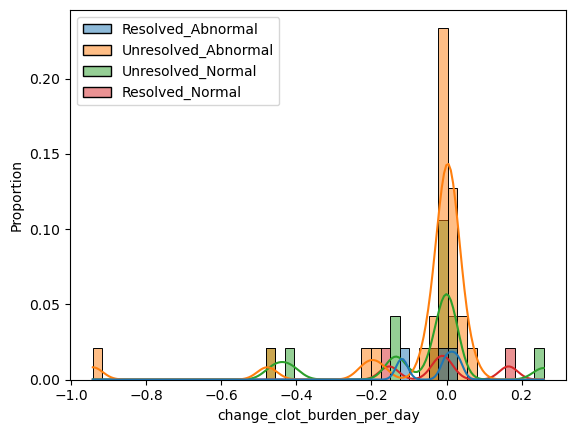

In [204]:
groupings = df['resolved_pe'].astype(str) + '_' + df['normal'].astype(str).map({'0': 'Abnormal', '1': 'Normal'})

sns.histplot(
	data=clot_burden_progression,
	x='change_clot_burden_per_day',
	hue=groupings,
	kde=True,
	stat='proportion',
	common_norm=True,
	kde_kws={'bw_adjust': 0.25}
)

plt.show()

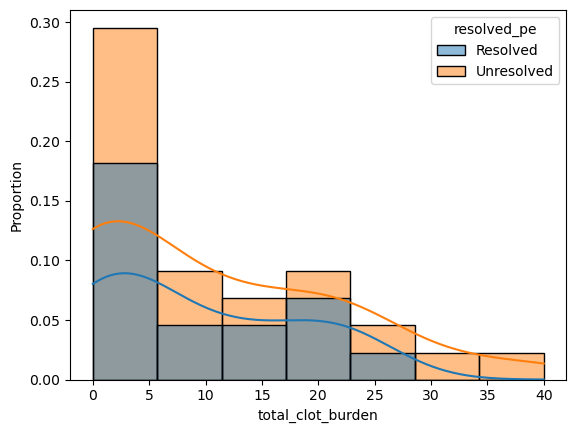

In [205]:
initial_obs = df.loc[df['pe_obs']==0, :]
initial_obs = initial_obs.dropna(subset='resolved_pe')

sns.histplot(
	data=initial_obs,
	x='total_clot_burden',
	hue='resolved_pe',
	kde=True,
	stat='proportion',
	common_norm=True,
	# kde_kws={'bw_adjust': 1.}
)

plt.show()

# data = [group_data['total_clot_burden'] for _, group_data in initial_obs.groupby('resolved_pe')]
# print(stats.mannwhitneyu(data[0], data[1]))
# print(stats.ttest_ind(data[0], data[1], equal_var=False))
# print(stats.ranksums(data[0], data[1]))

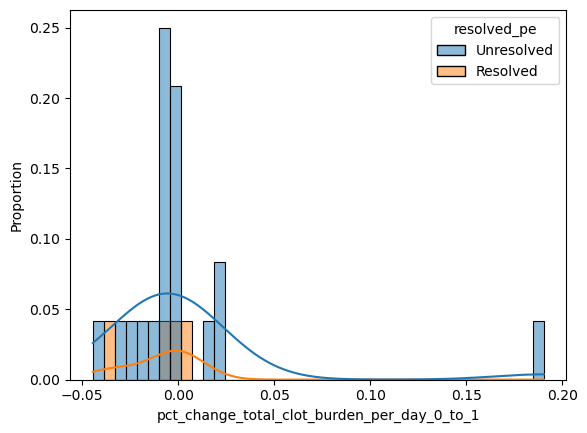

MannwhitneyuResult(statistic=40.0, pvalue=1.0)
Ttest_indResult(statistic=-0.9338176754689893, pvalue=0.3669712044568946)
RanksumsResult(statistic=0.0, pvalue=1.0)


In [206]:
df0 = num_data_initial.groupby(['PE_number', 'resolved_pe'])[['pct_change_total_clot_burden_per_day_0_to_1']].mean().dropna()

sns.histplot(
	data=df0,
	x='pct_change_total_clot_burden_per_day_0_to_1',
	hue='resolved_pe',
	kde=True,
	stat='proportion',
	common_norm=True,
	# kde_kws={'bw_adjust': 1.}
)

plt.show()

data = [group_data['pct_change_total_clot_burden_per_day_0_to_1'] for _, group_data in df0.groupby('resolved_pe')]
print(stats.mannwhitneyu(data[0], data[1]))
print(stats.ttest_ind(data[0], data[1], equal_var=False))
print(stats.ranksums(data[0], data[1]))

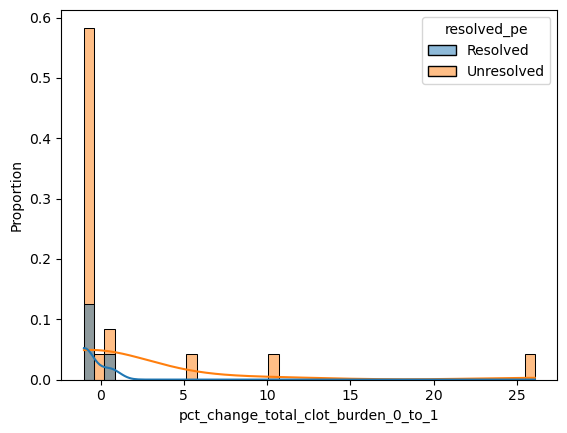

-0.5968125322706418
1.5284416357529385
MannwhitneyuResult(statistic=30.0, pvalue=0.460835497290101)
Ttest_indResult(statistic=-1.422250038979644, pvalue=0.16951347382628662)
RanksumsResult(statistic=-0.7745966692414834, pvalue=0.4385780260809998)


In [207]:
max_clot_burden = df.groupby(['PE_number', 'resolved_pe'])[['pct_change_total_clot_burden_0_to_1']].mean().dropna()

sns.histplot(
	data=max_clot_burden,
	x='pct_change_total_clot_burden_0_to_1',
	hue='resolved_pe',
	kde=True,
	stat='proportion',
	common_norm=True,
	# kde_kws={'bw_adjust': 1.}
)

plt.show()

data = [group_data['pct_change_total_clot_burden_0_to_1'] for _, group_data in max_clot_burden.groupby('resolved_pe')]
print(data[0].mean())
print(data[1].mean())
print(stats.mannwhitneyu(data[0], data[1]))
print(stats.ttest_ind(data[0], data[1], equal_var=False))
print(stats.ranksums(data[0], data[1]))

In [208]:
long_term = df.loc[(df['total_visits']>1) & (df['long_term_obs']), :]
short_term = df.loc[(df['total_visits']>1) & (~df['long_term_obs']), :]

print(long_term.shape)
print(short_term.shape)

long_term.head()

(38, 477)
(42, 477)


,pe_number_clean,patient_id,gender_pe,series_id,slice_number,centralartery,apical_rs1,posterior_rs2,anterior_rs3,lateral_rs4,...,previous_clot_burden,previous_study_date,pct_change_clot_burden,duration_prev_to_t_days,change_clot_burden_per_day,max_days_from_first_visit,long_term_obs,max_clot_burden,max_clot_burden_category,PE_number_num
PE15_0,PE15,HB046618,F,3.0,330.0,0.001022,0.00000,0.00000,0.000000,0.005451,...,NaN,NaT,NaN,NaN,NaN,892.0,True,0.153638,0-20 percentile,15.0
PE15_1,PE15,HB046618,F,3.0,323.0,0.000000,0.00000,0.00000,0.000000,0.000000,...,0.153638,2028-01-31,-1.000000,206.0,-0.000746,892.0,True,0.153638,0-20 percentile,15.0
PE15_2,PE15,HB046618,F,2.0,304.0,0.000000,0.00000,0.00000,0.000000,0.000000,...,0.000000,2028-08-24,inf,201.0,0.000030,892.0,True,0.153638,0-20 percentile,15.0
PE15_3,PE15,HB046618,F,2.0,383.0,0.000000,0.00000,0.00000,0.000000,0.000000,...,0.005953,2029-03-13,1.791234,485.0,0.000022,892.0,True,0.153638,0-20 percentile,15.0
PE18_0,PE18,HB046621,F,4.0,228.0,10.763400,1.12971,0.18561,0.007065,0.508018,...,NaN,NaT,NaN,NaN,NaN,2308.0,True,20.814575,60-80 percentile,18.0


## Progression Scatter Plot

C:\Users\qauster\AppData\Local\Temp\ipykernel_5600\3478257226.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  progression_data['heights'] = (


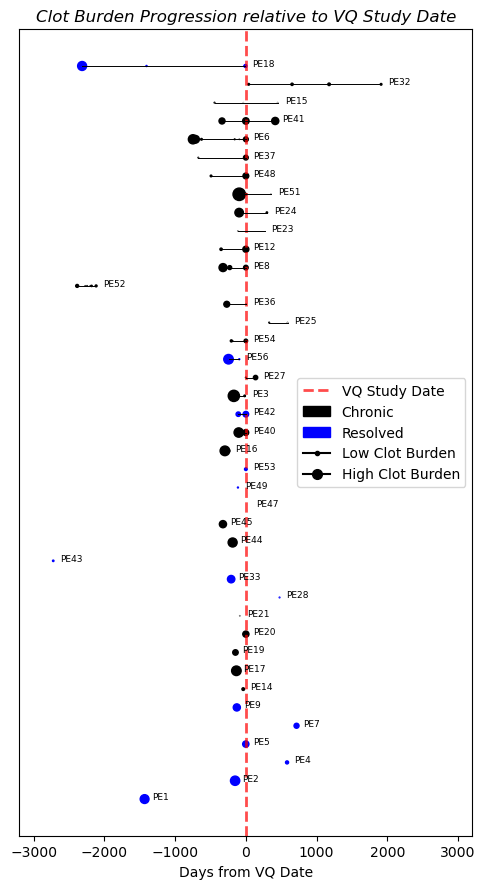

In [209]:
# Get complete progression data
# Use ranking system based on max date range to determine graphing heights
progression_data = df.dropna(subset=['duration_t_to_VQ_days', 'PE_number_num', 'total_clot_burden'])
progression_data['heights'] = (
	progression_data['date_range'] + progression_data['PE_number_num']
).transform(lambda x: x.rank(method='dense'))
progression_data = progression_data.sort_values(by=['heights', 'pe_obs'], ascending=False)

# Create color mapping for resolved/unresolved
color_mapping = {'Resolved': 'blue', 'Unresolved': 'black'}

# Plot figure
fig, axs = plt.subplots(figsize=(5, 9))

# Plot vertical line representing iCPET study date
vline = axs.axvline(
	x = 0, linestyle='--', linewidth=2.0, color = 'red', 
	alpha=0.7, label = 'VQ Study Date'
)

for patient_label, patient_data in progression_data.groupby('PE_number_num', as_index=False, sort=True):
	lines = axs.plot(
		patient_data['duration_t_to_VQ_days'], 
		patient_data['heights'], 
		c='black', linewidth=0.7
	)
	annot_x = patient_data['duration_t_to_VQ_days'][0]
	annot_y = patient_data['heights'][0]
	annot_x_offset = 100.
	annotation = plt.annotate(
		f'PE{str(int(patient_label))}', xy=(annot_x + annot_x_offset, annot_y), 
		xytext=(annot_x + annot_x_offset, annot_y),
		fontsize=6.5
	)

# Can plot all scatter data together (helps for legend)
scatter = axs.scatter(
	progression_data['duration_t_to_VQ_days'], 
	progression_data['heights'], 
	c=progression_data['resolved_pe'].map(color_mapping).astype(str), 
	s=progression_data['total_clot_burden'] * 2.0, 
	label='Clot Burden'
)
	
# Labeling
plt.title('Clot Burden Progression relative to VQ Study Date', fontstyle='oblique')
plt.xlabel('Days from VQ Date')

# Removing y-axis ticks and labels
plt.gca().set_yticks([])
plt.gca().set_yticklabels([])
plt.xlim([-3200, 3200])

# Set legend to display the scale of point sizes
black_patch = mpatches.Patch(color='black', label='Chronic')
blue_patch = mpatches.Patch(color='blue', label='Resolved')
small_mark = mlines.Line2D(
	[], [], color='black', marker='o',
	markersize=3, label='Low Clot Burden'
)
large_mark = mlines.Line2D(
	[], [], color='black', marker='o',
	markersize=7, label='High Clot Burden'
)

my_handles = [vline, black_patch, blue_patch, small_mark, large_mark]

legend = plt.legend(loc='center right', handles=my_handles)

# Save and plot
plt.tight_layout()
plt.savefig('../figures/clot_burden_progressions.png')
plt.show()

In [210]:
# Use to spot check accuracy of figure
df.loc[df['PE_number_num']==8, ['duration_t_to_VQ_days', 'total_clot_burden', 'resolved_pe']]

,duration_t_to_VQ_days,total_clot_burden,resolved_pe
PE8_0,-323.0,16.561007,Unresolved
PE8_1,-228.0,4.041189,Unresolved
PE8_2,0.0,5.546807,Unresolved


# Correlations

In [211]:
dead_space_features = [
    've_vco2_slope',
    've_vco2_at_at',
    'peak_vd_vt'
]
hemodynamic_features = [
    'mpap_co_ratio',
    'peak_measured_mpap_mmhg',
    'peak_pvr_wu',
    'peak_pa_elastance_ea_mmhg_ml_m2',
    'hyperventilation_num'
]

radiology_features = [
    'total_clot_burden',
    'num_positive_clot_burden_segments',
    'pct_change_total_clot_burden_0_to_1',
]

correlation_features = dead_space_features + hemodynamic_features + radiology_features
rows = radiology_features
cols = dead_space_features + hemodynamic_features

initial_correlation_data = num_data_initial.loc[:, correlation_features]
initial_correlation_data.corr().loc[rows, cols].sort_index().to_csv('../output/summary/corr_initial.csv')

last_prior_correlation_data = num_data_last_prior.loc[:, correlation_features]
last_prior_correlation_data.corr().loc[rows, cols].sort_index().to_csv('../output/summary/corr_last_prior_to_icpet.csv')

In [212]:
print(f"n={num_data_initial.shape[0]} for initial CTA") 

n=52 for initial CTA


In [213]:
df.filter(regex='slope').columns

Index(['ve_vco2_slope', 'vo2_work_slope_output'], dtype='object')

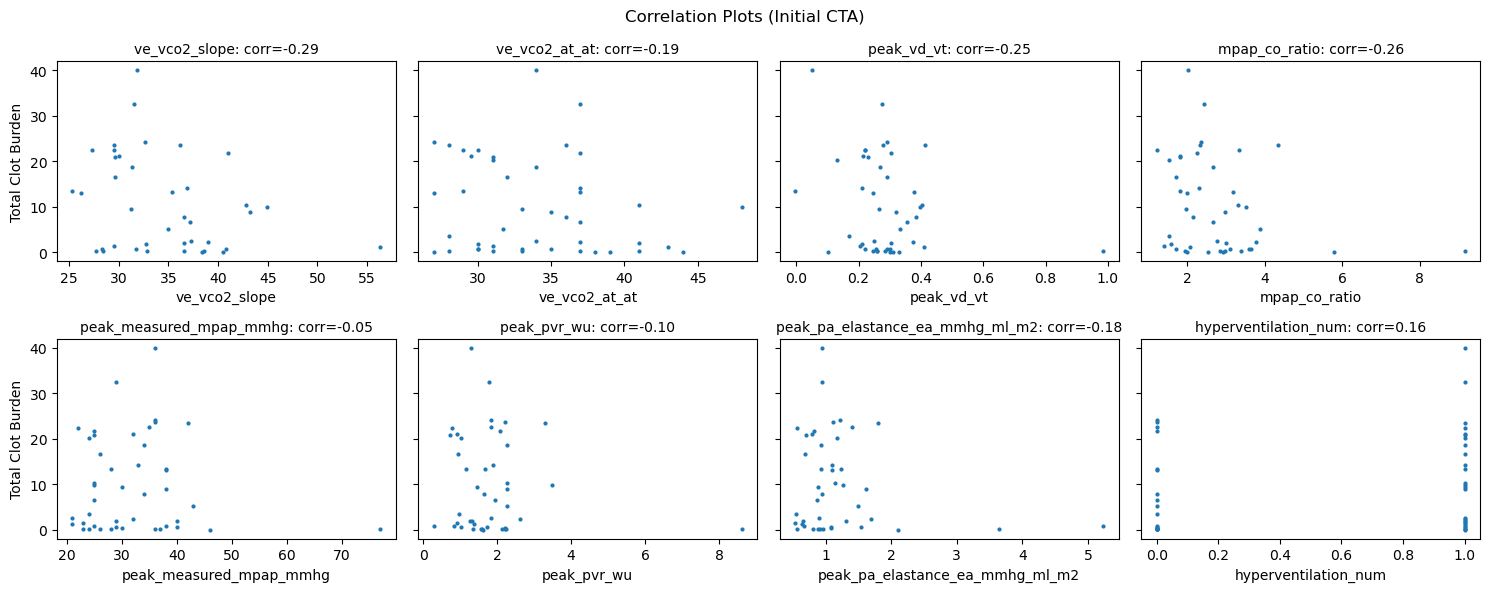

In [214]:
icpet_feat = dead_space_features + hemodynamic_features
n_rows = 2
n_cols = 4
fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 6), sharey=True)
for i, feat in enumerate(icpet_feat):
    row = i // n_cols
    col = i % n_cols
    axs[row, col].scatter(feat, 'total_clot_burden', data=initial_correlation_data, s=4)
    p = initial_correlation_data[['total_clot_burden', feat]].corr().iloc[1, 0]
    axs[row, col].set_title(f"{feat}: corr={p:.2f}", fontsize=10)
    axs[row, col].set_xlabel(feat)
    if col == 0:
        axs[row, col].set_ylabel('Total Clot Burden')
plt.suptitle('Correlation Plots (Initial CTA)')
plt.tight_layout()
plt.savefig('../figures/correlations_initial.png')

In [215]:
num_data_initial.loc[num_data_initial['total_clot_burden'] > 50, 'PE_number']

Series([], Name: PE_number, dtype: object)

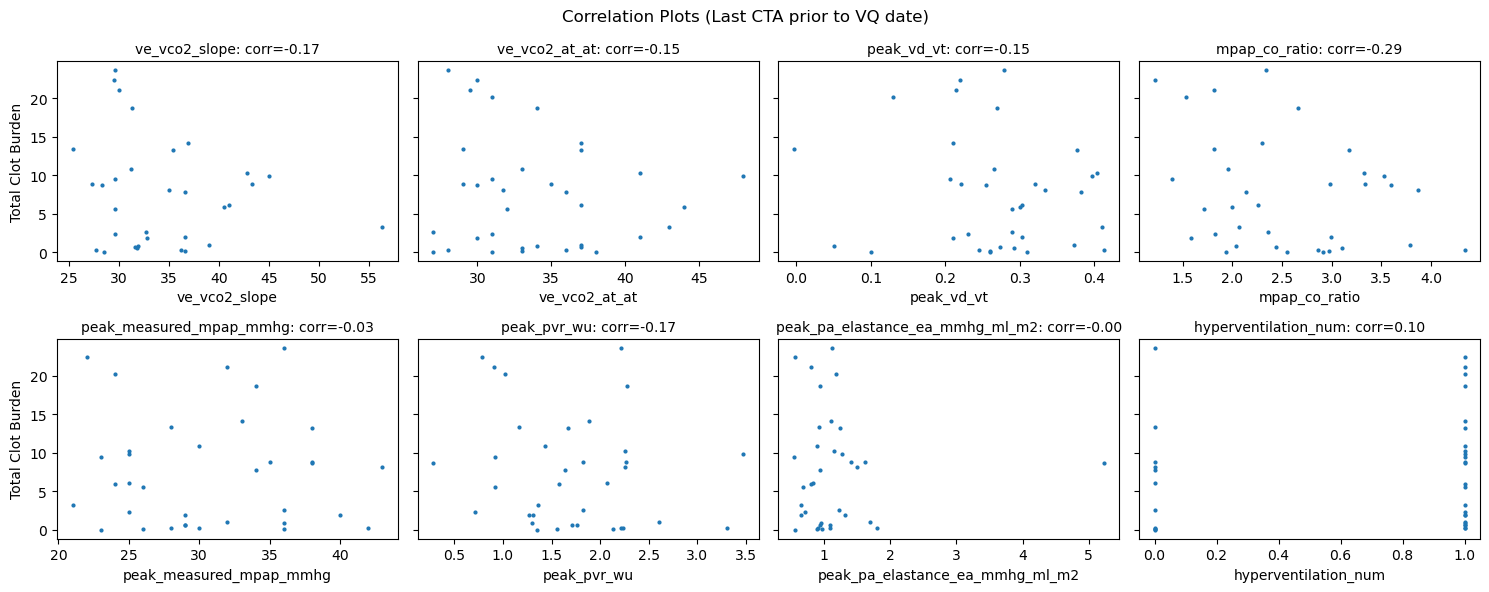

In [216]:
icpet_feat = dead_space_features + hemodynamic_features
n_rows = 2
n_cols = 4
fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 6), sharey=True)
for i, feat in enumerate(icpet_feat):
    row = i // n_cols
    col = i % n_cols
    axs[row, col].scatter(feat, 'total_clot_burden', data=last_prior_correlation_data, s=4)
    p = last_prior_correlation_data[['total_clot_burden', feat]].corr().iloc[1, 0]
    axs[row, col].set_title(f"{feat}: corr={p:.2f}", fontsize=10)
    axs[row, col].set_xlabel(feat)
    if col == 0:
        axs[row, col].set_ylabel('Total Clot Burden')
plt.suptitle('Correlation Plots (Last CTA prior to VQ date)')
plt.tight_layout()
plt.savefig('../figures/correlations_last_prior.png')

In [217]:
num_data_last_prior.loc[num_data_last_prior['total_clot_burden'] > 50, 'PE_number']

Series([], Name: PE_number, dtype: object)